<a href="https://www.kaggle.com/code/sumitduhan/vgg-ipynb?scriptVersionId=241154266" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/plant-seedlings-classification/sample_submission.csv
/kaggle/input/plant-seedlings-classification/test/fd87b36ae.png
/kaggle/input/plant-seedlings-classification/test/0e8492cb1.png
/kaggle/input/plant-seedlings-classification/test/8d6acbe9b.png
/kaggle/input/plant-seedlings-classification/test/54b3afd58.png
/kaggle/input/plant-seedlings-classification/test/6049234e6.png
/kaggle/input/plant-seedlings-classification/test/82b5f4d33.png
/kaggle/input/plant-seedlings-classification/test/a0f37c726.png
/kaggle/input/plant-seedlings-classification/test/e0ec5b6a1.png
/kaggle/input/plant-seedlings-classification/test/1cfd91582.png
/kaggle/input/plant-seedlings-classification/test/456d507c0.png
/kaggle/input/plant-seedlings-classification/test/d6d31dcbe.png
/kaggle/input/plant-seedlings-classification/test/e1abb4ff9.png
/kaggle/input/plant-seedlings-classification/test/aa7d098d1.png
/kaggle/input/plant-seedlings-classification/test/e19673dc9.png
/kaggle/input/plant-seedlings-classif

In [2]:
# VGG=Visual Geometry Group
# VGG16 & VGG19
# The input to this can network is a fixed 224x224 RGB image and the only preprocessing it does is substracting the mean RGB values, which are computed on the training dataset. from each pixel
# Then the image is running through stack of convolution layers, where there are filters with a very small recptive field that is 3x3 
# We have 13 convolution layer, 5 max_pooling layers, 3 fully connected layers
# Total parameters are 138 million

import numpy as np
import pandas as pd 
import os
from PIL import Image
from numpy import array
from numpy import asarray
import seaborn as sns
training_img_list=list()
path_to_train='/kaggle/input/plant-seedlings-classification/train'
shape_sum=0
class_name=dict()
train_avg_shape=80

for dirname, _, filenames in os.walk(path_to_train):
    for filename in filenames:
        img_data=Image.open(os.path.join(dirname, filename))
        resizedImage= img_data.resize((train_avg_shape, train_avg_shape))
        resizedImage= resizedImage.convert('RGB')
        resizedImage= asarray(resizedImage)/255

        class_label=dirname.split('/')[-1]
        training_img_list.append([resizedImage, class_label])
        shape_sum += np.max(img_data.size)
        class_name[class_label]=len(class_name)-1

In [3]:
from keras import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D


2025-05-22 06:01:59.523455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747893719.702147      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747893719.754813      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from sklearn.model_selection import KFold
from numpy import asarray
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

np.random.seed(17)
kf = KFold(n_splits=5)
epochs = 20
batch_size = 32

I0000 00:00:1747893732.221576      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


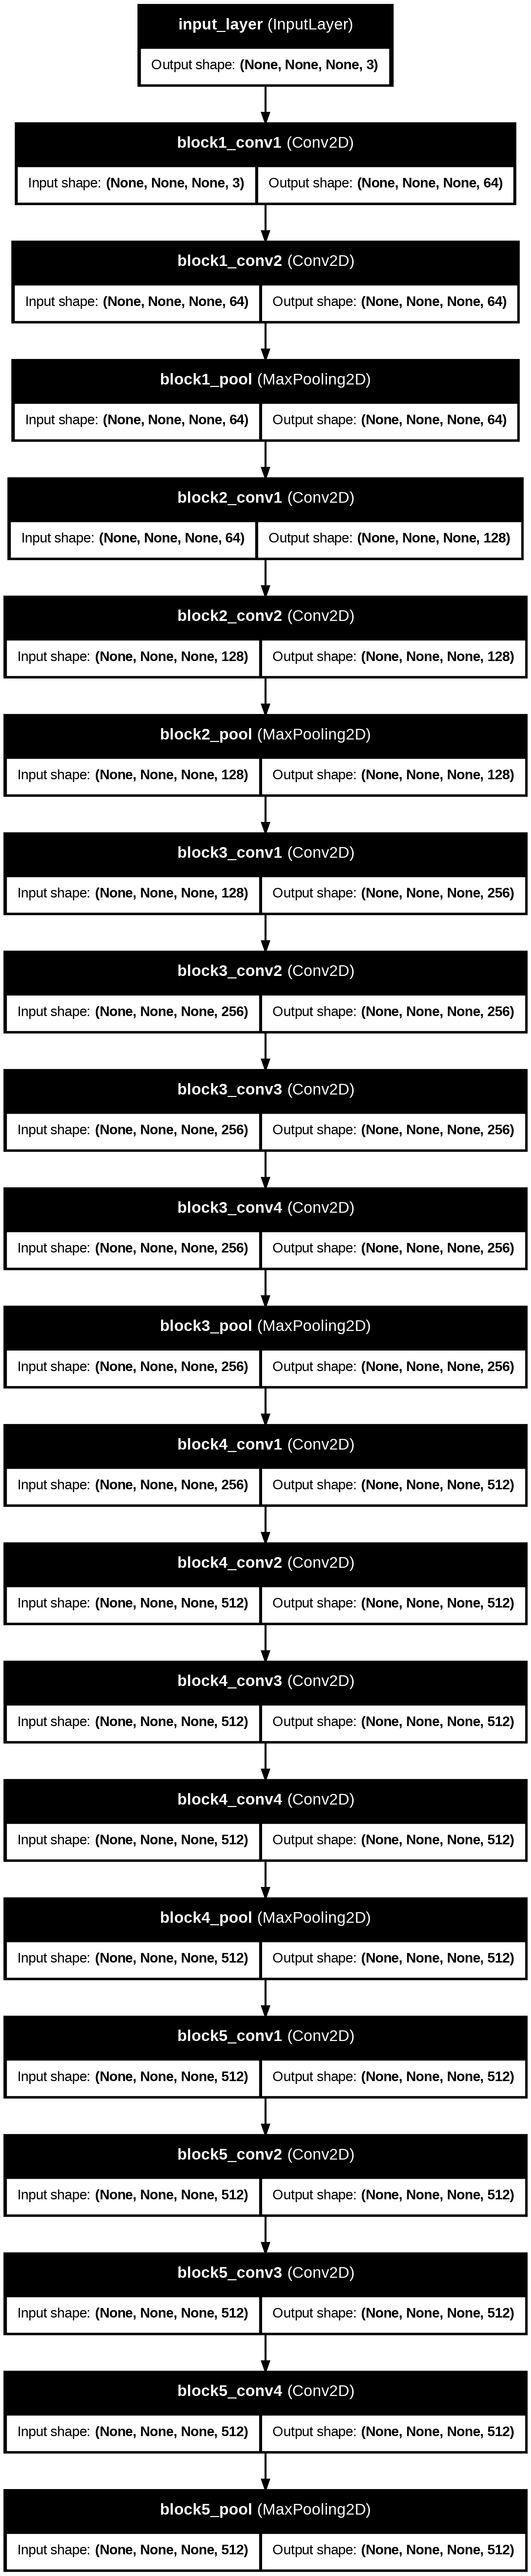

In [5]:
# Load VGG19 Model
from keras.applications.vgg19 import VGG19
vgg19_model = VGG19(weights='imagenet',include_top=False)
from keras.utils import plot_model
plot_model(vgg19_model, to_file='VGG19.png', show_shapes=True, show_layer_names=True)

In [6]:
vgg19_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
x=vgg19_model.output

In [8]:
from keras.layers import Dense,GlobalAveragePooling2D

x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(len(class_name), activation='softmax')(x) #final layer with softmax activation

In [9]:
from keras.models import Model
newModel=Model(inputs=vgg19_model.input,outputs=preds)
print("changed model layer count %d" %len(newModel.layers))
newModel.summary()

changed model layer count 27


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 22,130,252 (84.42 MB)

 Trainable params: 22,130,252 (84.42 MB)

 Non-trainable params: 0 (0.00 B)

VGG19 model after adding new layers

In [10]:
for layer in newModel.layers[:-5]:
    layer.trainable=False

newModel.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 22,130,252 (84.42 MB)

 Trainable params: 2,105,868 (8.03 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input

train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator=train_datagen.flow_from_directory(path_to_train, 
                                                  target_size=(80,80),
                                                  color_mode='rgb',
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=True)

Found 4750 images belonging to 12 classes.


In [12]:
newModel.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size
history = newModel.fit(train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=2)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2


I0000 00:00:1747893743.039092      58 service.cc:148] XLA service 0x7b4d9c005640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747893743.039660      58 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747893743.535598      58 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/148 ━━━━━━━━━━━━━━━━━━━━ 14:48 6s/step - accuracy: 0.0938 - loss: 2.5042

I0000 00:00:1747893746.334682      58 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


148/148 ━━━━━━━━━━━━━━━━━━━━ 51s 309ms/step - accuracy: 0.3268 - loss: 1.9489
Epoch 2/2
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 72us/step - accuracy: 0.5938 - loss: 1.2467  


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


History for cross validation fold 1


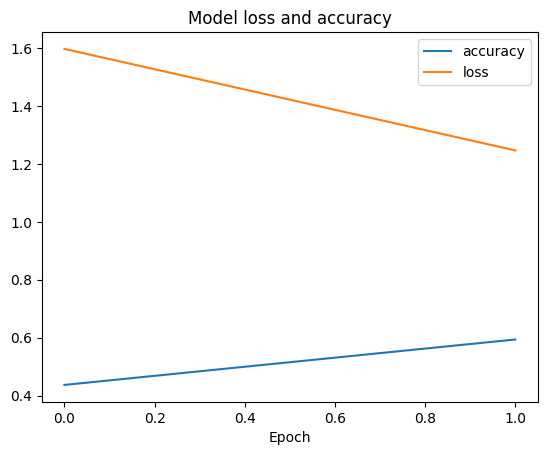

In [13]:
print("History for cross validation fold 1")
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Model loss and accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy','loss'], loc='upper right')
plt.show()

Load Test Data Set

In [14]:
pathToTestData ='/kaggle/input/plant-seedlings-classification/test'
test_img_list = list()

for dirname, _, filenames in os.walk(pathToTestData):
    for filename in filenames:
        img_data = Image.open(os.path.join(dirname, filename))
        
        resizedImage = img_data.resize((train_avg_shape, train_avg_shape))
        resizedImage = resizedImage.convert('RGB')
        resizedImage = asarray(resizedImage)/255

        test_img_list.append([resizedImage,filename])

In [15]:
X_test = np.zeros((len(test_img_list), train_avg_shape, train_avg_shape, 3), dtype='float32')

for i,img in enumerate(test_img_list):
    X_test[i] = test_img_list[i][0]

Predict On Test Data

In [16]:
predictions = newModel.predict(X_test, batch_size=None, verbose=0)
predictions=pd.DataFrame(predictions)

In [17]:
inverse_label_map = dict()
for k,v in train_generator.class_indices.items():
    inverse_label_map[v] = k

In [18]:
pred_label_num = predictions.idxmax(axis=1)
pred_label_num_new = list()

for x in pred_label_num:
    y = inverse_label_map[x]
    pred_label_num_new.append(y)

pred_label_num_new = pd.DataFrame(pred_label_num_new)
print(pred_label_num_new[0])


0       Loose Silky-bent
1             Sugar beet
2       Common Chickweed
3      Scentless Mayweed
4       Loose Silky-bent
             ...        
789             Cleavers
790     Loose Silky-bent
791             Cleavers
792    Scentless Mayweed
793                Maize
Name: 0, Length: 794, dtype: object


In [19]:
pred=pd.DataFrame()

In [20]:
testImages = pd.DataFrame(test_img_list) 
pred.insert(0,'file',testImages[1])
pred.insert(1,'species',pred_label_num_new[0])
pred.head()

,file,species
0,fd87b36ae.png,Loose Silky-bent
1,0e8492cb1.png,Sugar beet
2,8d6acbe9b.png,Common Chickweed
3,54b3afd58.png,Scentless Mayweed
4,6049234e6.png,Loose Silky-bent


In [21]:
pred.to_csv('predictionsVgg19.csv',index = None, header=True)